In [484]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary


In [485]:
# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

/var/folders/xc/5y8sdzl55133mlz80hkp_0sh0000gn/T/ipykernel_49178/2280885456.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [486]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [487]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [528]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=8,
        shuffle=True)

test = next(iter(data))
images8 = test[0]
labels8 = test[1]
f_image = images8[0]
print(f_image.shape) # [1, 28, 28] где 1 - это количество каналов
print(labels8[0].item()) # выведет цифру которой соответствует изображение, например 5

torch.Size([1, 28, 28])
5


In [458]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.layers =  nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Flatten()
        )
        self.linear1 = nn.Linear(256, latent_dims)
        self.linear2 = nn.Linear(256, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cpu() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cpu()
        self.kl = 0

    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x, start_dim=1)
        # print(x.shape)
        mu =  self.linear1(x)
        sigma = torch.exp(self.linear2(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1 / 2).sum()

        return z

In [459]:
# class Decoder(nn.Module):
#     def __init__(self, message_size):
#         super(Decoder, self).__init__()
#         self.linear1 = nn.Linear(message_size, 512)
#         self.linear2 = nn.Linear(512, 784)
#
#     def forward(self, picture):
#         picture = F.relu(self.linear1(picture))
#         picture = torch.sigmoid(self.linear2(picture))
#         return picture.reshape((-1, 1, 28, 28))

In [460]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.latent_dims = latent_dims
        self.linear1 = nn.Linear(latent_dims, 128)  # Соответствует размерности выхода после линейного слоя в энкодере
        # self.linear2 = nn.Linear(128, 128 * 4)  # Соответствует размерности передачи из линейного слоя в ConvTranspose2d в энкодере
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=6, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=6, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.linear1(z)
        # x = self.linear2(x)
        # x = torch.flatten(x, start_dim=1)
        x = x.view(-1, 32, 2, 2)  # Соответствует размерности после линейного слоя в энкодере
        x = self.layers(x)
        return x


In [461]:
class Autoencoder(nn.Module):
    def __init__(self, message_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(message_size)
        self.decoder = Decoder(message_size)

    def forward(self, picture):
        picture = self.encoder(picture)
        return self.decoder(picture)

In [462]:
def train(autoencoder_model, train_data, epochs=20):
    opt = torch.optim.SGD(autoencoder_model.parameters())
    criterion = nn.MSELoss()
    running_loss = 0.0
    for _ in range(epochs):
        for x, y in train_data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder_model(x)
            # print([x.shape, x_hat.shape])
            # break
            loss = ((x - x_hat) ** 2).sum()
            loss.backward()
            opt.step()
            loss2 = criterion(x_hat, x)
            running_loss += loss2.item() * x.size(0)
        print(f"Loss: {running_loss/len(train_data)}")
    return autoencoder

In [463]:
autoencoder = Autoencoder(256).to(device) # GPU

In [477]:
autoencoder_1 = train(autoencoder, data, epochs=10)

Loss: 0.06225306843171517
Loss: 0.10951542537038525
Loss: 0.1497826375717918
Loss: 0.1860346964687109
Loss: 0.21950876481657228
Loss: 0.25076780747398736
Loss: 0.2803812782290081
Loss: 0.3085142580943803
Loss: 0.33539703221855066
Loss: 0.3612615506106367


In [478]:
sample = next(iter(data))
print(sample[0])
digit_sample = sample[0]
print(digit_sample.shape)
print(digit_sample)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [479]:
encoded_sample = autoencoder.encoder.forward(digit_sample)
print(encoded_sample)

tensor([[ 0.9054, -1.4532, -1.1826,  ..., -0.8282,  0.8963,  0.2708],
        [ 0.6923,  0.9482, -1.6059,  ...,  1.0926, -1.9333,  1.2686],
        [-0.1800, -0.5589, -0.3100,  ..., -1.0368,  0.3244, -0.6585],
        ...,
        [-0.1940,  1.2395,  0.3790,  ...,  0.5600, -0.1204,  0.9674],
        [ 0.0971,  0.3436,  0.8949,  ..., -1.8168,  0.8197,  0.0958],
        [ 0.2245, -0.1110, -0.3995,  ..., -0.9781,  1.9087, -1.4418]],
       grad_fn=<AddBackward0>)


In [480]:
print(autoencoder.decoder.forward(encoded_sample))

tensor([[[[6.9348e-03, 7.4691e-04, 7.8957e-04,  ..., 1.2183e-03,
           9.4592e-04, 3.1352e-03],
          [6.9652e-04, 3.4428e-06, 4.6651e-05,  ..., 1.6594e-05,
           1.0821e-04, 7.0305e-05],
          [9.5140e-04, 6.4981e-05, 7.0917e-05,  ..., 6.3676e-04,
           2.1121e-04, 4.6221e-04],
          ...,
          [8.9578e-04, 5.6881e-06, 4.1656e-05,  ..., 1.5291e-05,
           1.1706e-04, 9.6105e-05],
          [1.2892e-03, 1.0711e-04, 9.9187e-05,  ..., 1.3590e-04,
           1.0377e-04, 1.0210e-03],
          [4.2648e-03, 5.5190e-05, 7.7536e-04,  ..., 7.3053e-05,
           5.9341e-04, 4.2136e-04]]],


        [[[7.1023e-03, 7.4299e-04, 7.1438e-04,  ..., 1.0030e-03,
           8.1953e-04, 3.3447e-03],
          [8.1148e-04, 3.5561e-06, 4.8116e-05,  ..., 6.1185e-06,
           5.2633e-05, 4.2987e-05],
          [9.4198e-04, 5.4212e-05, 7.0275e-05,  ..., 9.2651e-05,
           6.7073e-05, 7.1145e-04],
          ...,
          [3.9427e-04, 7.4133e-07, 1.4343e-05,  ..., 8.22

In [481]:
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import numpy as np

In [482]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

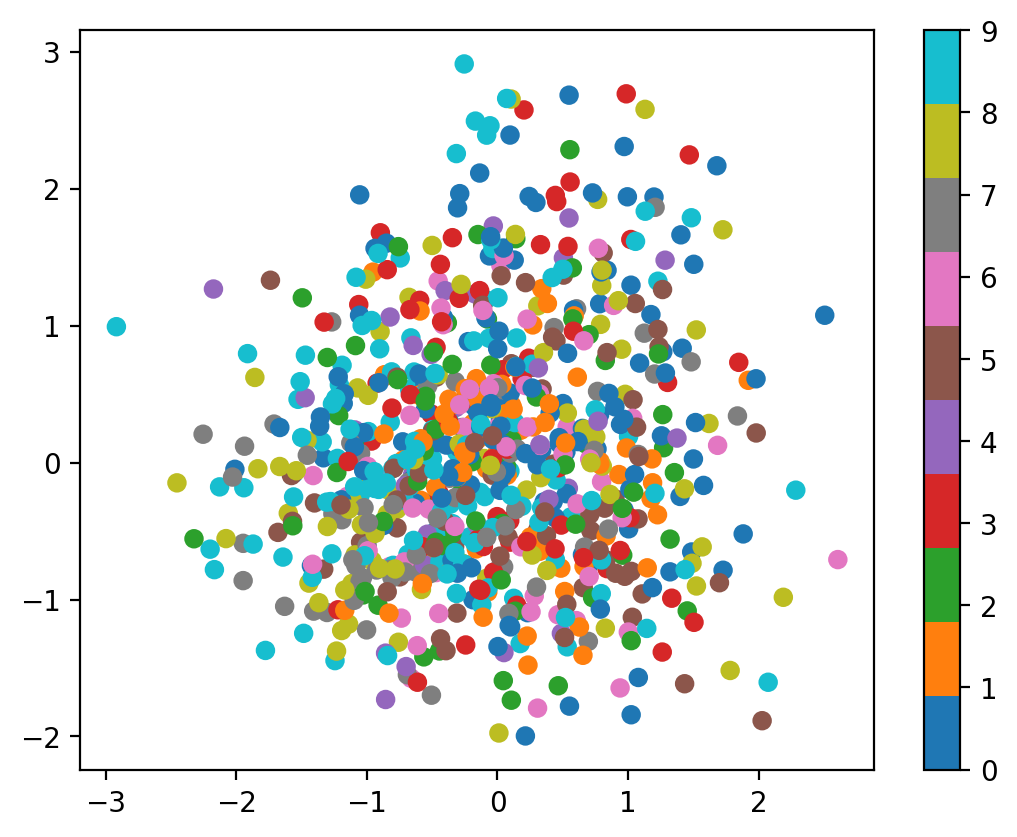

In [483]:
plot_latent(autoencoder_1, data)

In [474]:
plot_reconstructed(autoencoder)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 256x128)

In [475]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [476]:
x, y = next(iter(data)) # hack to grab a batch
# print(y)
# print(x[0][0].shape)
x_1 = x[y == 3].to(device) # find a 1
x_2 = x[y == 7].to(device) # find a 0
print(x_1[1][0])

IndexError: index 1 is out of bounds for dimension 0 with size 0

In [200]:
interpolate(autoencoder, x_1, x_2, n=20)

ValueError: could not broadcast input array from shape (28,28) into shape (28,0)

In [169]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([3, 3, 2, 3, 1])

result = x[y == 3]

print(result)

[1 2 4]
